In [1]:
import os
from pathlib import Path

from src.seg_openseed import OpenSeeDSeg
from src.dataset import collate_fn
from src.dataset.nutrition5k_dataset import Nutrition5kDataset, make_dataset
from src.dataset import Metadata
from OpenSeeD.utils.visualizer import Visualizer

from detectron2.data import MetadataCatalog
from detectron2.utils.colormap import random_color
from detectron2.structures import BitMasks

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torchvision.transforms.functional import to_pil_image

metadatas_path = '/srv/datasets2/nutrition5k_dataset/metadata/dish_metadata_cafe1.csv'
imgs_dir = '/srv/datasets2/nutrition5k_dataset/imagery/realsense_overhead'
splits_path = '/srv/datasets2/nutrition5k_dataset/dish_ids/splits/depth_train_ids.txt'
splits_test_path = '/srv/datasets2/nutrition5k_dataset/dish_ids/splits/depth_test_ids.txt'
splits =  [line.rstrip() for line in open(splits_path,'r').readlines()]

/home/parinayok/.pyenv/versions/miniconda3-latest/envs/nutrition5k/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = make_dataset(None,imgs_dir,metadatas_path,splits_path,splits_test_path,unnormalized_int_tensor=True)
dataloader = {x: DataLoader(dataset[x], batch_size=1, num_workers=8, shuffle=True if x == 'train' else False, collate_fn=collate_fn) for x in ['train','test']}

unnormalized


In [3]:
openseed_seg = OpenSeeDSeg('cuda')

Metadata(name='demo', thing_colors=[[170, 255, 0]], thing_classes=['food'], thing_dataset_id_to_contiguous_id={0: 0})


/home/parinayok/.pyenv/versions/miniconda3-latest/envs/nutrition5k/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


self.task_switch  {'coco': True, 'o365': False}


$UNUSED$ criterion.empty_weight, Ckpt Shape: torch.Size([134])
$UNUSED$ sem_seg_head.predictor.lang_encoder.lang_encoder.positional_embedding, Ckpt Shape: torch.Size([18, 512])
*UNMATCHED* sem_seg_head.predictor.lang_encoder.lang_encoder.positional_embedding, Model Shape: torch.Size([77, 512]) <-> Ckpt Shape: torch.Size([18, 512])


In [4]:
from torchvision import transforms
index = 250
img = []
depth = []
mask = []
for i, batch in enumerate(dataloader['train']):
  if i == 5:
    break
  img.append(batch['rgb_img'])
  depth.append(batch['depth_img'])
  mask.append(batch['mask'])
img = torch.concat(img)
depth = torch.concat(depth)
mask = torch.concat(mask)
resize = transforms.Resize((256, 352))
img = resize(img)
depth = resize(depth)
mask = mask.unsqueeze(1)
mask = resize(mask)
mask = mask.squeeze(1)
# img = img*255
# img = img.expand(-1, 3, -1, -1)

/home/parinayok/.pyenv/versions/miniconda3-latest/envs/nutrition5k/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


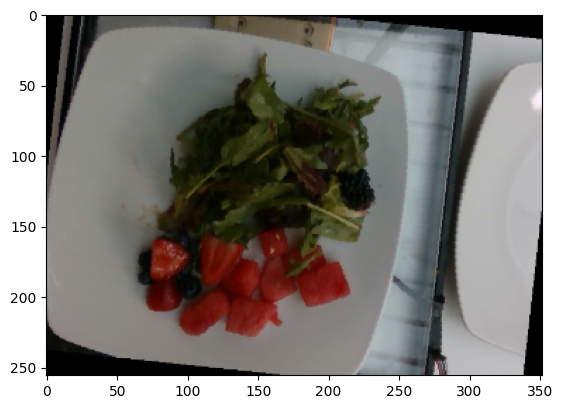

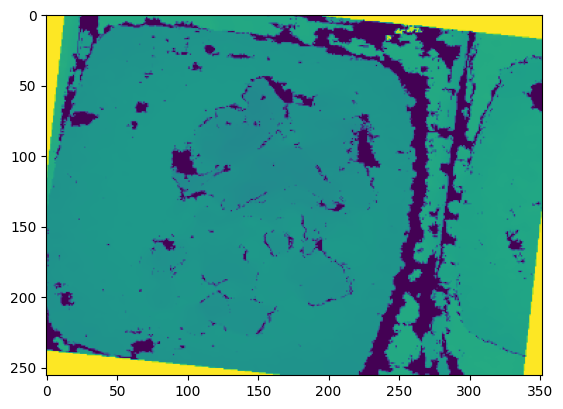

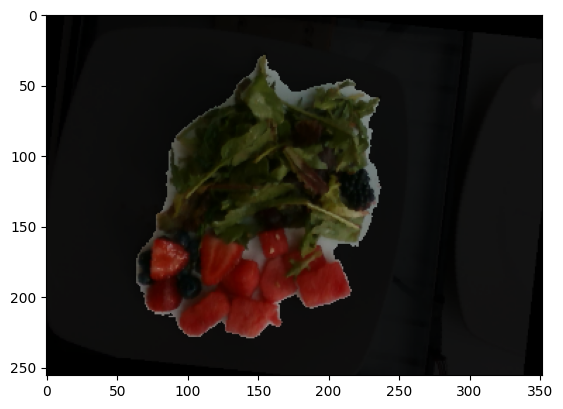

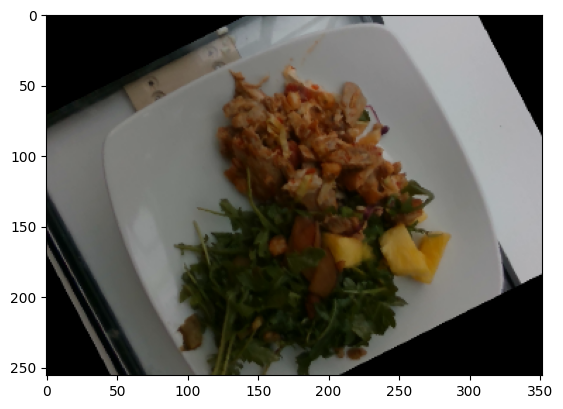

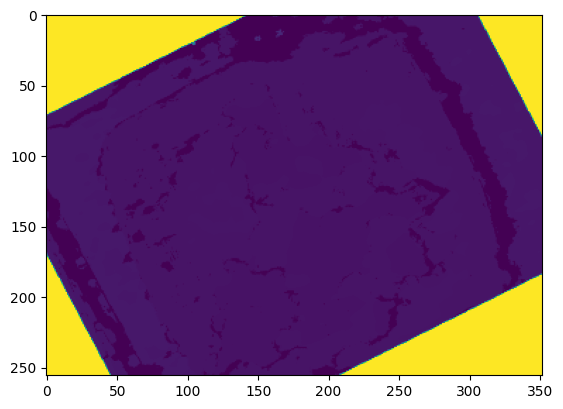

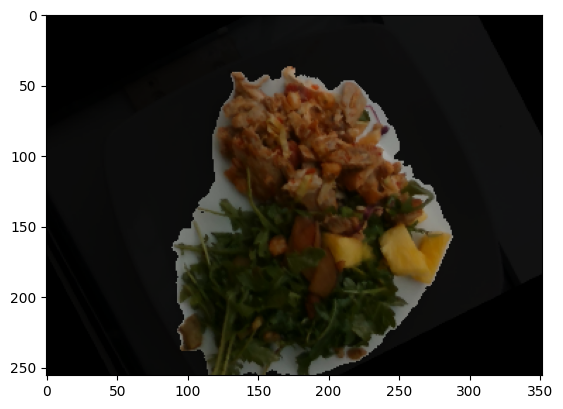

In [7]:
plt.figure()
plt.imshow(img[0].int().permute(1,2,0))
plt.figure()
plt.imshow((depth[0]).permute(1,2,0))
plt.figure()
plt.imshow((img[0]*torch.where(mask[0],mask[0],0.1)).int().permute(1,2,0))
plt.figure()
plt.imshow(img[1].int().permute(1,2,0))
plt.figure()
plt.imshow((depth[1]).permute(1,2,0))
plt.figure()
plt.imshow((img[1]*torch.where(mask[1],mask[1],0.1)).int().permute(1,2,0))

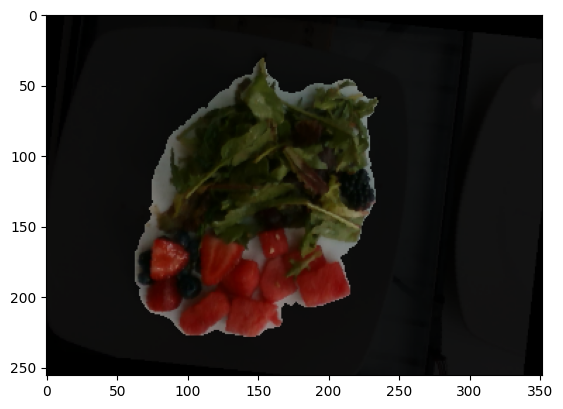

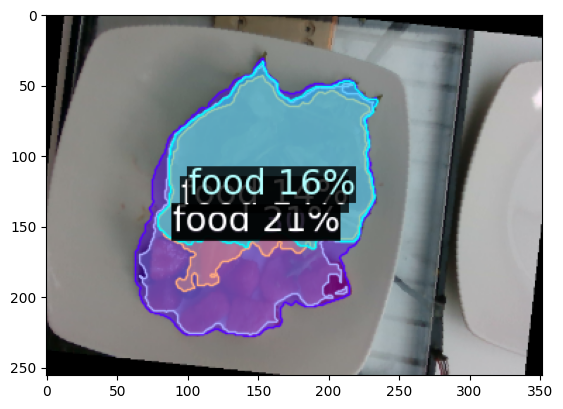

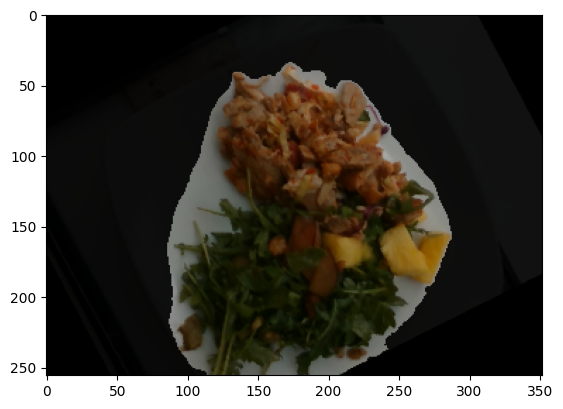

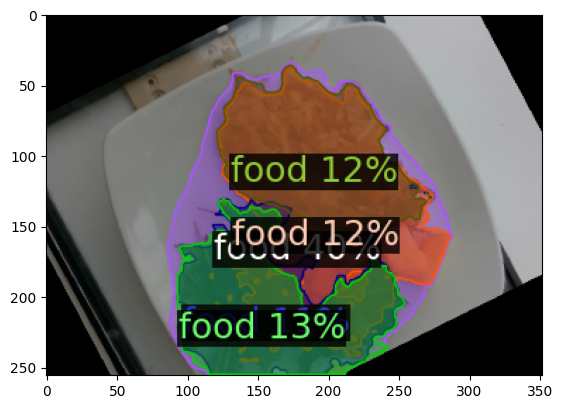

In [8]:
mask, inst_seg, features = openseed_seg.get_mask(img)
mask = mask.cpu()
plt.figure()
plt.imshow((img[0]*torch.where(mask[0].bool(),mask[0].int(),0.1)).int().permute(1,2,0))
metadata = MetadataCatalog.get('demo')
visual = Visualizer(img[0].permute(1,2,0), metadata=metadata)
inst_seg[0].pred_masks = inst_seg[0].pred_masks.cpu()
demo = visual.draw_instance_predictions(inst_seg[0], threshold=0.1)
plt.figure()
plt.imshow(demo.get_image())
plt.figure()
plt.imshow((img[1]*torch.where(mask[1].bool(),mask[1].int(),0.1)).int().permute(1,2,0))
metadata = MetadataCatalog.get('demo')
visual = Visualizer(img[1].permute(1,2,0), metadata=metadata)
inst_seg[1].pred_masks = inst_seg[1].pred_masks.cpu()
demo = visual.draw_instance_predictions(inst_seg[1], threshold=0.1)
plt.figure()
plt.imshow(demo.get_image())

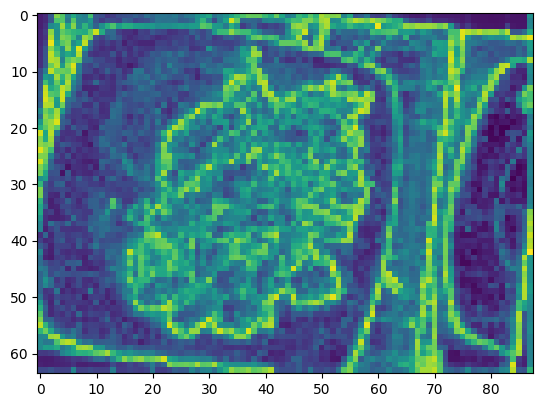

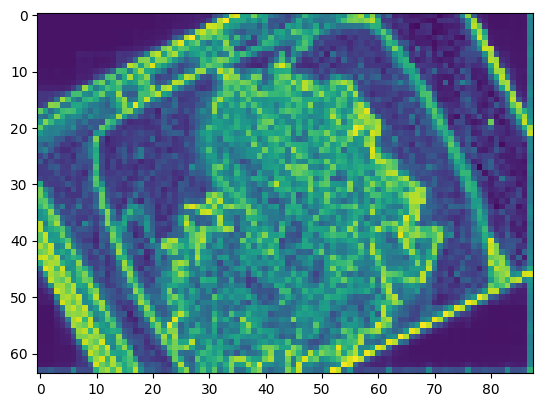

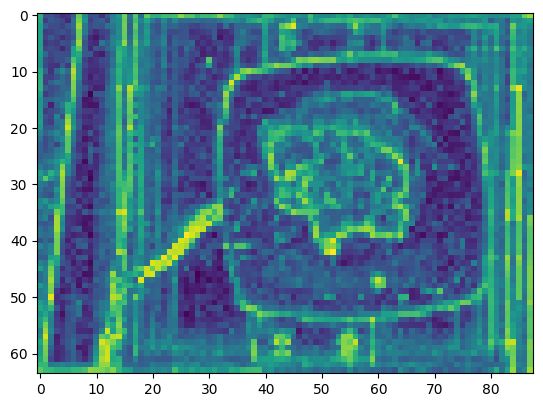

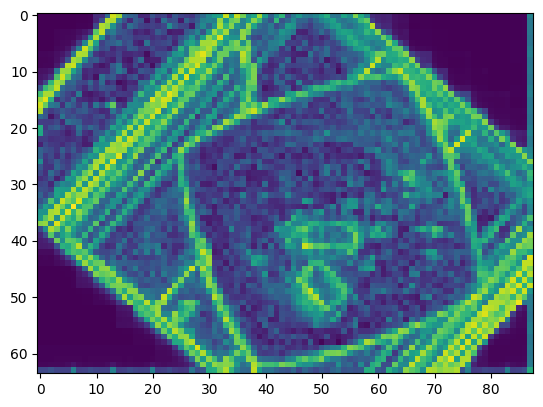

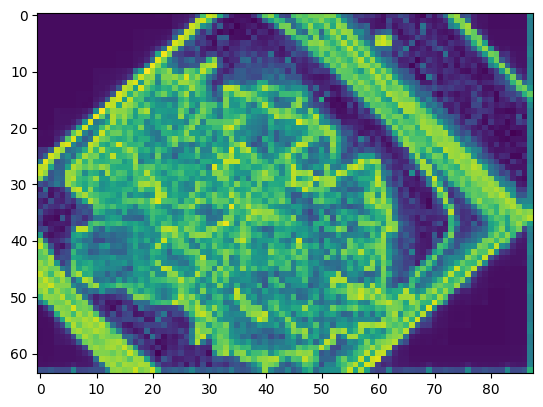

In [9]:
for feat in features.values():
    for f in feat:
        plt.figure()
        plt.imshow(f.abs().mean(0).cpu())
    break

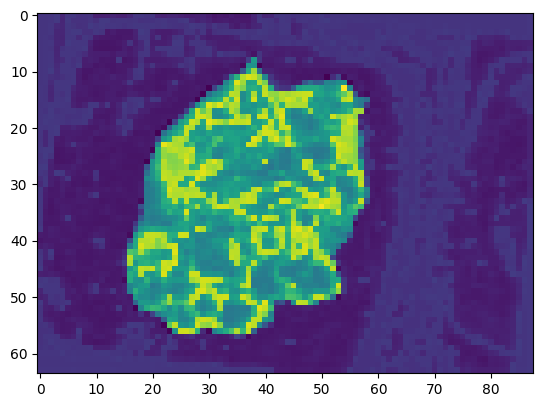

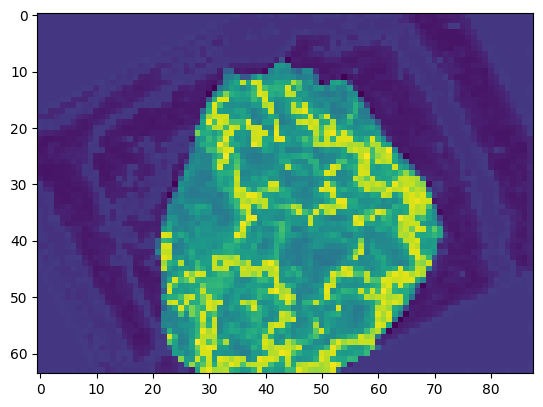

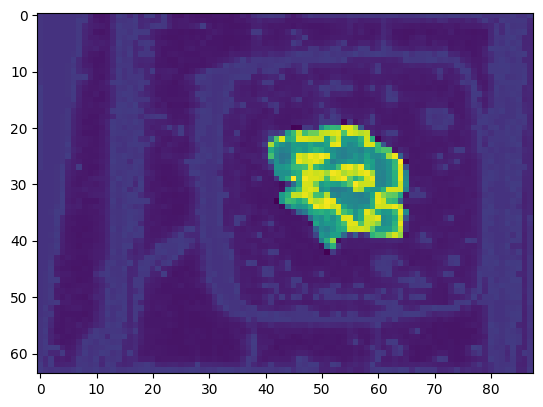

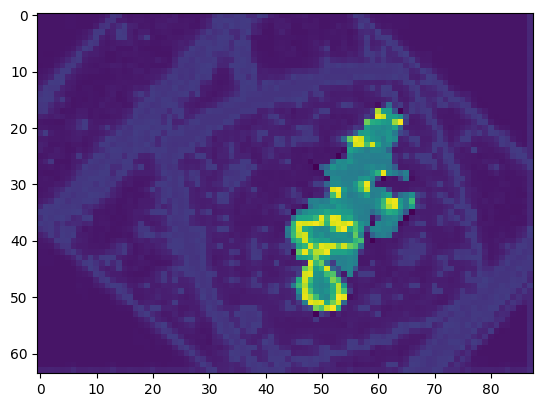

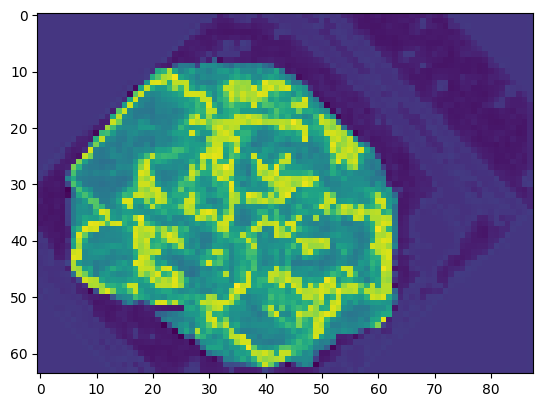

In [15]:
import torch.nn.functional as f
_, _, features = openseed_seg.get_mask(depth)
for feat in features.values():
    for i, hid in enumerate(feat):
        m = mask[i].unsqueeze(0)
        hid = hid.cpu()
        m = f.adaptive_avg_pool2d(m.float(),(hid.shape[-2],hid.shape[-1]))
        m = torch.where(m.bool(),m,0.2)
        new_hid = hid * m
        plt.figure()
        plt.imshow(new_hid.abs().mean(0).cpu())
    break

In [5]:
import sys
sys.path.append('src')
from model import FPNOpenSeeD, Regressor

model = FPNOpenSeeD(512, regressor = Regressor(2048,2048)).to('cuda')
out, features = model(img,img)

self.task_switch  {'coco': True, 'o365': False}


$UNUSED$ criterion.empty_weight, Ckpt Shape: torch.Size([134])
$UNUSED$ sem_seg_head.predictor.lang_encoder.lang_encoder.positional_embedding, Ckpt Shape: torch.Size([18, 512])
*UNMATCHED* sem_seg_head.predictor.lang_encoder.lang_encoder.positional_embedding, Model Shape: torch.Size([77, 512]) <-> Ckpt Shape: torch.Size([18, 512])


self.task_switch  {'coco': True, 'o365': False}


$UNUSED$ criterion.empty_weight, Ckpt Shape: torch.Size([134])
$UNUSED$ sem_seg_head.predictor.lang_encoder.lang_encoder.positional_embedding, Ckpt Shape: torch.Size([18, 512])
*UNMATCHED* sem_seg_head.predictor.lang_encoder.lang_encoder.positional_embedding, Model Shape: torch.Size([77, 512]) <-> Ckpt Shape: torch.Size([18, 512])


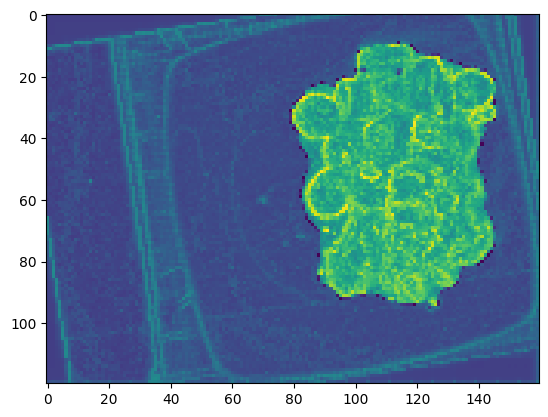

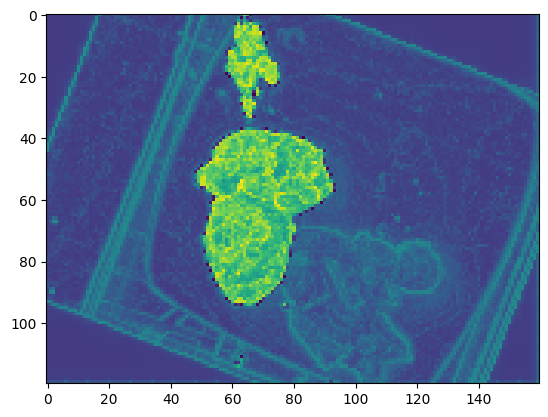

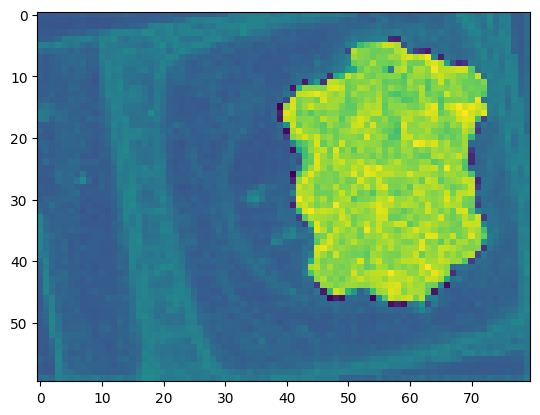

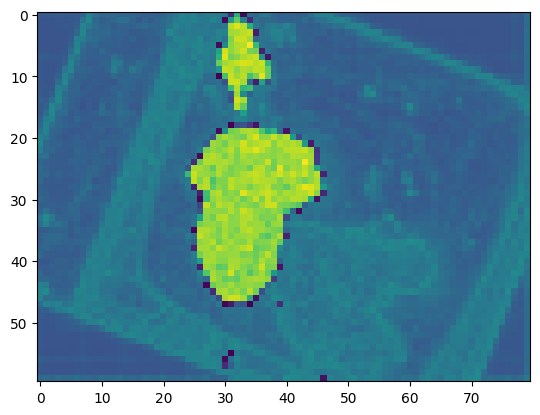

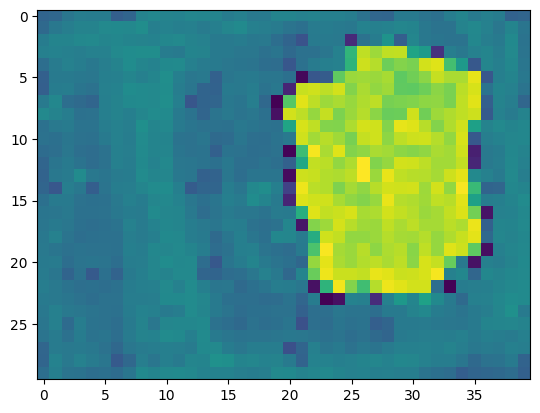

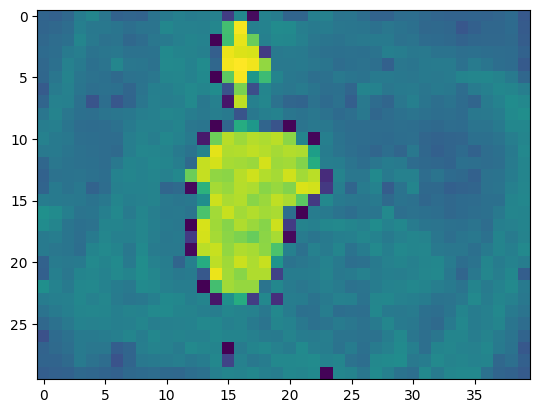

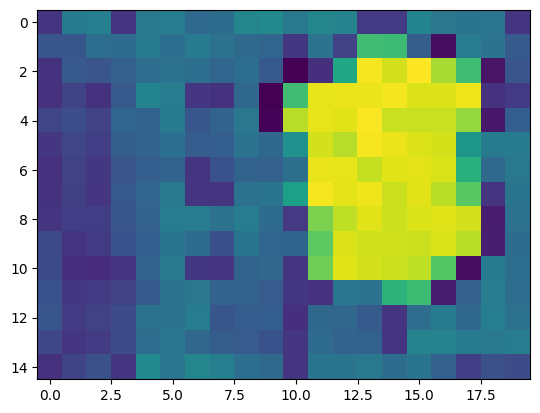

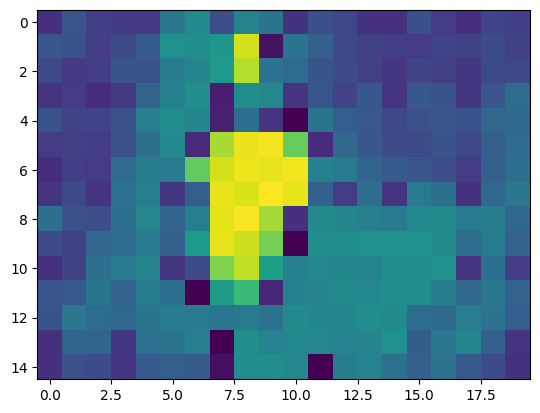

In [6]:
for feat in features.values():
    for f in feat:
        plt.figure()
        plt.imshow(f.abs().mean(0).cpu())

In [4]:

thing_classes = ['food']
# thing_classes = ['car','person','traffic light', 'truck', 'motorcycle', 'cheetah', 'jellyfish', 'parachute']
thing_colors = [random_color(rgb=True, maximum=255).astype(int).tolist() for _ in range(len(thing_classes))]
thing_dataset_id_to_contiguous_id = {x:x for x in range(len(thing_classes))}

MetadataCatalog.get("demo").set(
    thing_colors=thing_colors,
    thing_classes=thing_classes,
    thing_dataset_id_to_contiguous_id=thing_dataset_id_to_contiguous_id,
)

namespace(name='demo',
          thing_colors=[[0, 255, 127]],
          thing_classes=['food'],
          thing_dataset_id_to_contiguous_id={0: 0})

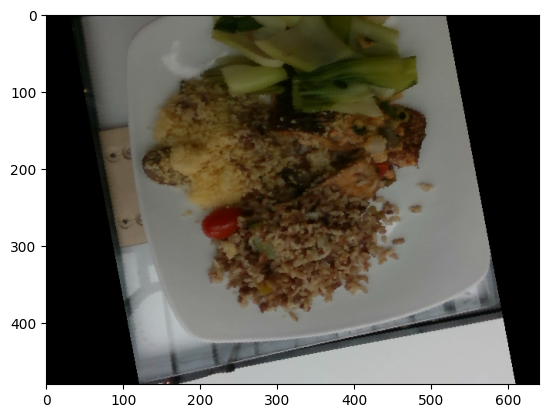

In [5]:
index = 33
# img_dir = Path.joinpath(dataset['train'].imgs_dir,dataset['train'].splits[index]) 
# rgb_path = Path.joinpath(img_dir,'rgb.png')
# image_ori = Image.open(rgb_path).convert("RGB")
img = dataset['train'][33]['rgb_img']
# img = img * 0.23 + 0.45
# img *= 255
# img = img.int()
# image_pth = 'Xdecoder/animals.png'
# image_ori = Image.open(image_pth).convert("RGB")
# # width = image_ori.size[0]
# # height = image_ori.size[1]
# # image = transform(image_ori)
# # image = np.asarray(image)
# image_ori = np.asarray(image_ori)
# img = torch.from_numpy(image_ori.copy()).permute(2,0,1)
plt.imshow(img.permute(1,2,0))

In [6]:
outputs = seg(img,torch.device('cuda'))

/home/parinayok/.pyenv/versions/miniconda3-latest/envs/nutrition5k/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


self.task_switch  {'coco': True, 'o365': False}


$UNUSED$ criterion.empty_weight, Ckpt Shape: torch.Size([134])
$UNUSED$ sem_seg_head.predictor.lang_encoder.lang_encoder.positional_embedding, Ckpt Shape: torch.Size([18, 512])
*UNMATCHED* sem_seg_head.predictor.lang_encoder.lang_encoder.positional_embedding, Model Shape: torch.Size([77, 512]) <-> Ckpt Shape: torch.Size([18, 512])


In [7]:
# stuff_classes = ['food']
# stuff_colors = [random_color(rgb=True, maximum=255).astype(int).tolist() for _ in range(len(stuff_classes))]
# stuff_dataset_id_to_contiguous_id = {x:x for x in range(len(stuff_classes))}

metadata = MetadataCatalog.get('demo')
visual = Visualizer(img.permute(1,2,0), metadata=metadata)
inst_seg = outputs[-1]['instances']
inst_seg.pred_masks = inst_seg.pred_masks.cpu()
inst_seg.pred_boxes = BitMasks(inst_seg.pred_masks > 0).get_bounding_boxes()
demo = visual.draw_instance_predictions(inst_seg, threshold=0.1)
# plt.imshow(img.permute(1,2,0))
# plt.imshow(demo.get_image())

['name',
 'thing_colors',
 'thing_classes',
 'thing_dataset_id_to_contiguous_id',
 '__module__',
 '__annotations__',
 '__doc__',
 '_RENAMED',
 '__getattr__',
 '__setattr__',
 'as_dict',
 'set',
 'get',
 '__weakref__',
 '__new__',
 '__repr__',
 '__getattribute__',
 '__delattr__',
 '__lt__',
 '__le__',
 '__eq__',
 '__ne__',
 '__gt__',
 '__ge__',
 '__init__',
 '__reduce__',
 '__dict__',
 '__hash__',
 '__str__',
 '__reduce_ex__',
 '__subclasshook__',
 '__init_subclass__',
 '__format__',
 '__sizeof__',
 '__dir__',
 '__class__']

2


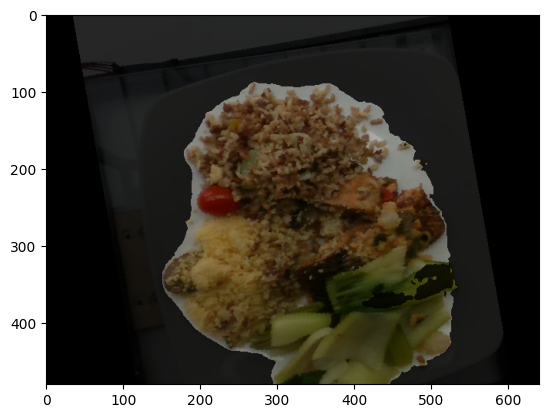

In [7]:
scores = inst_seg.scores.cpu()
classes = inst_seg.pred_classes.cpu()
masks = inst_seg.pred_masks
# keep = torch.logical_and(scores > 0.1,classes!=0)
keep = scores > 0.1
masks = masks[keep]
print(len(masks))
mask = masks.max(0)[0]
plt.figure()
plt.imshow((img*torch.where(mask.bool(),mask.int(),0.2)).int().permute(1,2,0))
# plt.figure()
# plt.imshow(mask)

In [ ]:
mask = inst_seg.pred_masks
print(mask.shape)
print(mask.max())
print(mask.min())
mask = mask[:10].max(0)[0]
print(mask.shape)
print(mask.max())
print(mask.min())
# plt.imshow(mask)

torch.Size([100, 480, 640])
tensor(1.)
tensor(0.)
torch.Size([480, 640])
tensor(1.)
tensor(0.)


In [20]:
from transformers import AutoProcessor, GroupViTModel
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name = "nvidia/groupvit-gccyfcc"
model = GroupViTModel.from_pretrained(model_name)
processor = AutoProcessor.from_pretrained(model_name)
model.to(device)
print(device)

Some weights of the model checkpoint at nvidia/groupvit-gccyfcc were not used when initializing GroupViTModel: ['vision_model.encoder.stages.1.layers.0.attention.output.dense.weight', 'vision_model.encoder.stages.0.layers.4.output.dense.bias', 'vision_model.encoder.stages.1.layers.0.layernorm_after.bias', 'vision_model.encoder.stages.1.layers.2.output.dense.bias', 'vision_model.encoder.stages.0.layers.0.attention.output.dense.weight', 'vision_model.encoder.stages.1.layers.0.layernorm_after.weight', 'vision_model.encoder.stages.0.layers.1.attention.attention.key.bias', 'vision_model.encoder.stages.2.layers.2.attention.output.dense.weight', 'vision_model.encoder.stages.0.layers.5.attention.attention.value.bias', 'vision_model.encoder.stages.0.layers.5.intermediate.dense.bias', 'vision_model.encoder.stages.1.layers.2.output.dense.weight', 'vision_model.encoder.stages.0.layers.3.attention.attention.key.weight', 'vision_model.encoder.stages.0.layers.4.layernorm_after.weight', 'vision_model.

cuda


In [27]:
thing_classes = ['rice','plate','chopsticks','food','meat','vegetables']
thing_colors = [random_color(rgb=True, maximum=255).astype(int).tolist() for _ in range(len(thing_classes))]
inputs = processor(
    text=[f"a photo of {word}" for word in thing_classes],
    images=torch.clip(img,0,1),
    return_tensors="pt",
    padding=True,
).to(device)

In [28]:
outputs = model(**inputs, output_segmentation=True)
logits = outputs.segmentation_logits

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


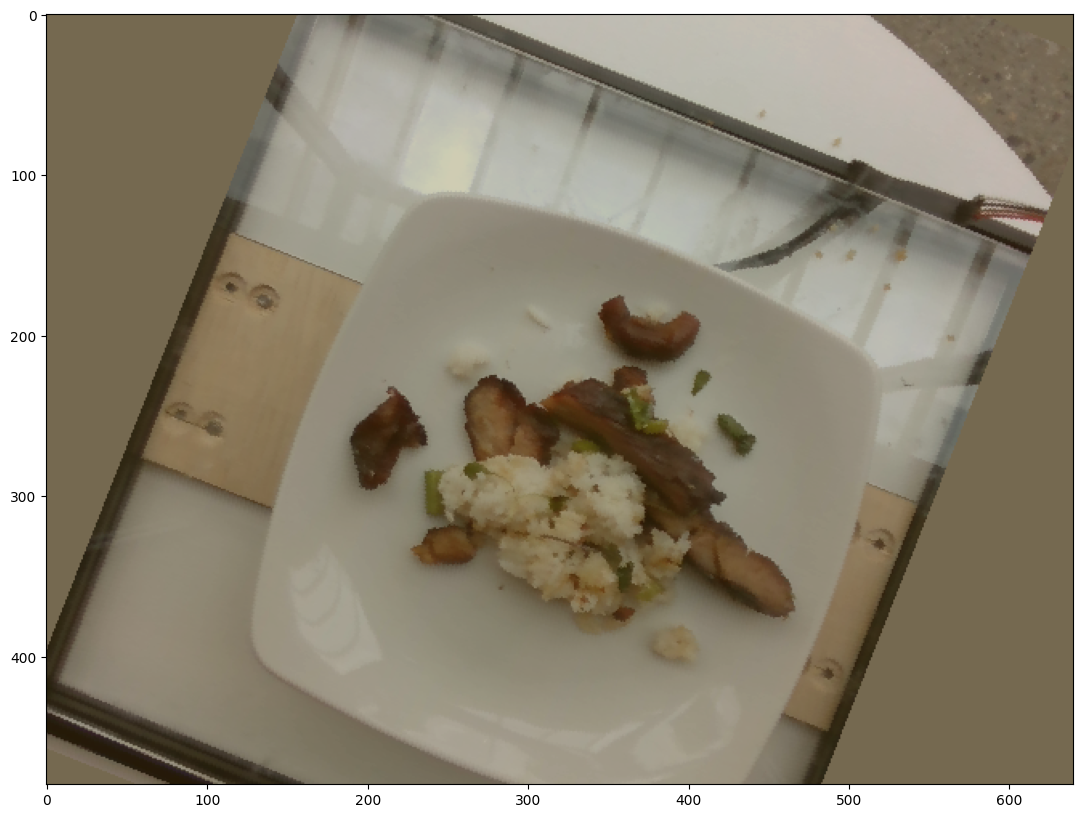

In [29]:
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

# First, rescale logits to original image size
logits = nn.functional.interpolate(logits.detach().cpu(),
                size=(img.shape[-2],img.shape[-1]), # (height, width)
                mode='bilinear',
                align_corners=False)

# Second, apply argmax on the class dimension
seg = logits.argmax(dim=1)[0]
color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8) # height, width, 3
palette = np.array(thing_colors)
for label, color in enumerate(palette):
    color_seg[seg == label, :] = color
# Convert to BGR
color_seg = color_seg[..., ::-1]

plt.figure(figsize=(15, 10))
plt.imshow(img.permute(1,2,0))
plt.imshow(color_seg,alpha=0.3)
plt.show()

In [2]:
0.95**20

0.3584859224085419

In [4]:
import torch
mask = torch.load('/srv/datasets2/nutrition5k_dataset/imagery/realsense_overhead/dish_1561753021/mask.pt')

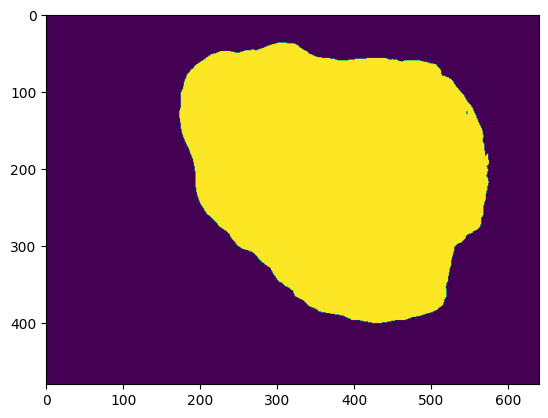

In [5]:
import matplotlib.pyplot as plt
plt.imshow(mask)

In [6]:
mask.shape

torch.Size([480, 640])